# Convolutions and rescalings

We briefly explore here essential parts of a convolutional network: convolutions and rescaling funcitons.

In [1]:
import skimage
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

We use here as an example an image from scikit-image. It is a regular image, i.e. it is composed of three channels. Here we load it and transform it into a Tensor as needed by the deep learning library PyTorch:

In [ ]:
# Imports an image from skimage.data
image = skimage.data.chelsea()
image_torch = torch.tensor(image, dtype=torch.float32)


We can verify that the image indeed as three channels.

In [3]:
image.shape

(300, 451, 3)

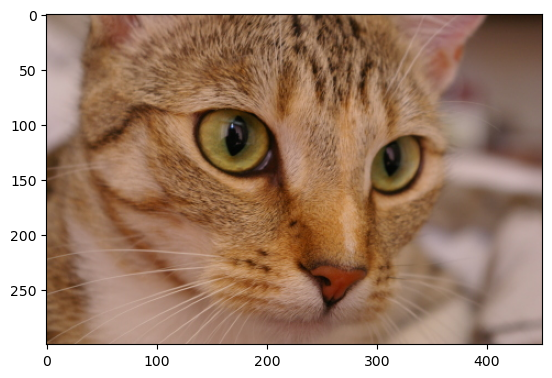

In [4]:
plt.imshow(image);

## Layers

We have seen in previous chapters how to create simple networks with linear layers. Here we use another type of layer: the two-dimensional convolution. This layer takes images as input and therefore we don't need to linearize the images. We can also choose:

- how many channels we have as input. This is similar to the number of inputs we had for the linear layer
- how many output channels we want. This is again similar to the number of outputs in a linear layer.
- the size of the filter or the ```kernel_size```. Larger filters consider larger regions and thus "look" at larger objects
- finally we have additional options controlling the input size, how the filter moves across the image etc. that we don't detail here.

The input and output number of channels represent here actual number of 2D images. For example for our RGB image which has three channels, we have in fact three separate 2D images. Hence the layer needs three inputs. The number of outputs can be chosen. Here we set it to 5:

In [ ]:
# Creates a neural network with a single hidden layer
from torch import nn

In [25]:
# Creates a convolutaional layer
conv_layer = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(10,10))

In [26]:
conv_layer.weight

Parameter containing:
tensor([[[[ 0.0463,  0.0424,  0.0266,  ..., -0.0121,  0.0349, -0.0241],
          [ 0.0228, -0.0519,  0.0110,  ...,  0.0080, -0.0193, -0.0462],
          [-0.0065, -0.0529,  0.0315,  ...,  0.0467,  0.0166, -0.0104],
          ...,
          [ 0.0290, -0.0501,  0.0232,  ...,  0.0280,  0.0522,  0.0008],
          [ 0.0125,  0.0047, -0.0314,  ...,  0.0338, -0.0422, -0.0125],
          [-0.0212, -0.0414,  0.0239,  ...,  0.0431, -0.0143, -0.0556]],

         [[ 0.0482, -0.0461, -0.0319,  ..., -0.0367,  0.0231,  0.0020],
          [ 0.0258, -0.0243,  0.0546,  ...,  0.0263,  0.0112,  0.0137],
          [-0.0245, -0.0303, -0.0487,  ..., -0.0495,  0.0300, -0.0070],
          ...,
          [-0.0112,  0.0416, -0.0129,  ..., -0.0115, -0.0227,  0.0542],
          [-0.0389,  0.0203, -0.0286,  ...,  0.0368, -0.0257, -0.0449],
          [ 0.0176,  0.0077, -0.0400,  ..., -0.0431,  0.0056,  0.0399]],

         [[-0.0129,  0.0342, -0.0012,  ..., -0.0207, -0.0030,  0.0183],
        

We want to create a deep learning model, so we add our layer to a ```Sequential``` object, a standard model composed of a sequence of layers:

In [7]:
model = nn.Sequential(conv_layer)

Finally, we can pass out image as input. We only have to make sure the channel dimension comes first. We also need to add a "dummy" dimension for the batch (we could pass multiple images at the same time to the model):

In [8]:
out = model(torch.moveaxis(image_torch,2,0)[np.newaxis,:])

In [9]:
out.shape

torch.Size([1, 5, 291, 442])

The output has indeed 5 channels. We can visualize them to see what happend to our original image:

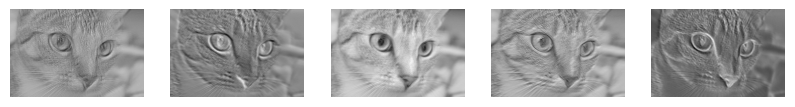

In [10]:
fig, axes = plt.subplots(1,5, figsize=(10,3))
for ax, im in zip(axes, out[0]):
    ax.imshow(im.detach().numpy(), cmap='gray')
    ax.set_axis_off()

Even though initialization is random, we see that each element in our convolutional layer is a filter that highlights specific aspects of the image.

## Deeper model

If we were constructing an actual model, we would now add more layers. Just like we had to take care that the number of outputs of a linear layer matched the number of inputs of the next layer, we need to make sure that the number of out-channels corresponds to the in-channels of the next layer. For example:

In [ ]:
conv_layer1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(10,10))
conv_layer2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=(10,10))

model2 = nn.Sequential(conv_layer1, conv_layer2)

In [27]:
out2 = model2(torch.moveaxis(image_torch,2,0)[np.newaxis,:])

In [28]:
out2.shape

torch.Size([1, 2, 282, 433])

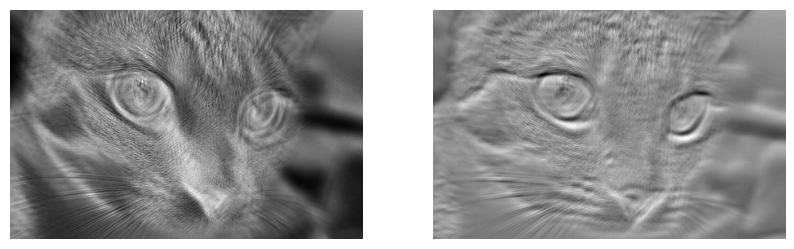

In [29]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
for ax, im in zip(axes, out2[0]):
    ax.imshow(im.detach().numpy(), cmap='gray')
    ax.set_axis_off()

We see that the images are already blurrier than before as they result now from the combination of multiple filtered images.

## Activations

Again as in a linear model, we need to add activations between layers to help the model discover interesting features. Here the activation function operated directly on the output images of each layer. Let's add some activations:

In [30]:
conv_layer1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(10,10))
conv_layer2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=(10,10))
# Adds a ReLU layer between the two convolutional layers
model3 = nn.Sequential(conv_layer1, nn.ReLU(), conv_layer2, nn.ReLU())

out3 = model3(torch.moveaxis(image_torch,2,0)[np.newaxis,:])

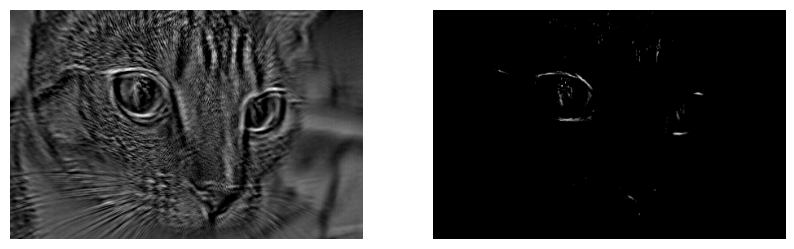

In [ ]:
# Activation works like this. It switches some of the values in the matrix to 0.
fig, axes = plt.subplots(1,2, figsize=(10,3))
for ax, im in zip(axes, out3[0]):
    ax.imshow(im.detach().numpy(), cmap='gray')
    ax.set_axis_off()

## Rescaling

As we have learned, we need to reduce the size of the image to capture larger scale features. We have seen for that Average or Maximum pooling. Again there are pre-made layer for that. For example:

In [34]:
av_pool = nn.AvgPool2d(kernel_size=10)
max_pool = nn.MaxPool2d(kernel_size=10)

In [39]:
conv_layer1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=(10,10))
conv_layer2 = nn.Conv2d(in_channels=5, out_channels=2, kernel_size=(10,10))

model4 = nn.Sequential(conv_layer1, nn.ReLU(), conv_layer2, nn.ReLU(), av_pool)

out4 = model4(torch.moveaxis(image_torch,2,0)[np.newaxis,:])

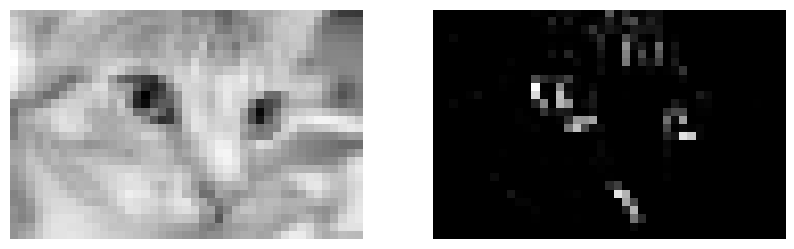

In [40]:
fig, axes = plt.subplots(1,2, figsize=(10,3))
for ax, im in zip(axes, out4[0]):
    ax.imshow(im.detach().numpy(), cmap='gray')
    ax.set_axis_off()